# 4. Topic modeling

*Generate the most-frequent words for each dataset, excluding stop words.*

In [1]:
!pip install nltk
!pip install wordcloud

In [2]:
import datetime
import functools
import io
import itertools
import os
from pathlib import Path
import re
from timeit import default_timer

import matplotlib.pyplot as plt
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import sqlite3
from wordcloud import WordCloud

In [3]:
%matplotlib notebook
pd.options.display.float_format = '{:.2f}'.format
nltk.download('stopwords')
#nltk.download('popular')

[nltk_data] Downloading package stopwords to /home/sarah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
!cd ../data; python3 preprocess.py

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, GotPdi7ND5U93CiLruCUjAPr0R5af8PkKEZQ9UJHNlE= to 8K26YsyMwaxAbofr9cYRDbjIDwf5kYJkp1FqGZB+A=
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   user_display_name         70 non-null     object
 1   user_screen_name          70 non-null     object
 2   user_reported_location    25 non-null     object
 3   user_profile_description  27 non-null     object
 4   user_profile_url          4 non-null      object
 5   follower_count            70 non-null     int64 
 6   following_count           70 non-null     int64 
 7   account_creation_date     70 non-null     object
 8   account_language          70 non-null     object
 9   campaign                  70 non-null     object
 10  release                   70 non-null     object
 11  government                70 non-null     object
 12  file                      70 non-null     object
dtypes: i

In [5]:
campaigns = ['GRU202012']
ts = datetime.datetime.now()
name = '{}_{}'.format(campaigns, ts)

log = []
log.append('Datasets: {}\n'.format(campaigns))

users_combined = pd.read_csv('../data/users_combined.csv',
                             index_col='userid',
                             low_memory=False)
tweets_combined = pd.read_csv('../data/tweets_combined.csv',
                              index_col='tweetid',
                              low_memory=False)

users = users_combined.loc[:][users_combined['campaign'].isin(campaigns)]
tweets = tweets_combined.loc[:][tweets_combined['campaign'].isin(campaigns)]

tweets_dtypes = {
    'user_display_name':'string',
    'user_screen_name':'string',
    'user_reported_location':'string',
    'user_profile_description':'string',
    'user_profile_url':'string',
    'account_creation_date':'datetime64',
    'account_language':'string',
    'tweet_language':'string',
    'tweet_text':'string',
    'tweet_time':'datetime64',
    'tweet_client_name':'category',
    'latitude':'category',
    'longitude':'category',
    'campaign':'string',
    'government':'string',
    'file':'string'}
users_dtypes = {
    'user_display_name':'string',
    'user_screen_name':'string',
    'user_reported_location':'string',
    'user_profile_description':'string',
    'user_profile_url':'string',
    'follower_count':'int64',
    'following_count':'int64',
    'account_creation_date':'datetime64',
    'account_language':'string',
    'campaign':'string',
    'government':'string',
    'file':'string'}

tweets = tweets.astype(tweets_dtypes)
users = users.astype(users_dtypes)

## Pipeline:

1. Generate a new column in the dataframe containing a list of keywords for each tweet, produced by tokenizing the tweet text and removing stop words using the stop word list provided in the ```nltk``` library.
2.  Use these keyword lists to generate frequency bins for keywords in the total set of tweets.

In [6]:
def format_text(df):
    return df.str.replace(r'[^\w\s]', '').str.replace(r'http\S+', '')

In [8]:
keywords = tweets['tweet_text'].pipe(format_text)

In [9]:
t_0 = default_timer()
keywords = keywords.map(word_tokenize)
t_1 = default_timer()
print('tokenize time: {}'.format(t_1 - t_0))

tokenize time: 2.663774094020482


In [10]:
cache = set(stopwords.words())
t_0 = default_timer()
keywords = keywords.apply(
                    lambda tokens: [word for word in tokens if word.lower() not in cache])
t_1 = default_timer()
print('stopword filtering: {}'.format(t_1 - t_0))

stopword filtering: 0.09576542998547666


In [11]:
all_words = [*itertools.chain.from_iterable(keywords)]
word_dict = {}

for word in all_words:
    if word in word_dict:
        word_dict[word] += 1
    else:
        word_dict[word] = 1

word_freq = sorted(word_dict.items(), key=lambda item: item[1], reverse=True)

<IPython.core.display.Javascript object>


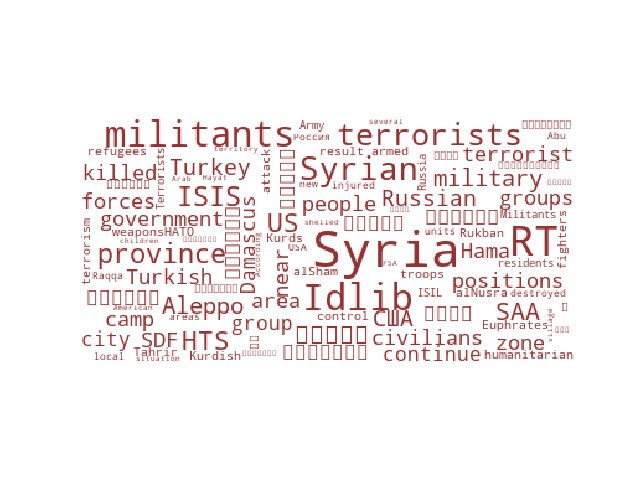

In [12]:
cloud = WordCloud(background_color="white",
                  prefer_horizontal=0.9,
                  max_font_size=40,
                  relative_scaling=.5,
                  color_func=lambda *args,**kwargs:(150,50,50))
cloud.generate_from_frequencies(dict(word_freq[:100]))

plt.figure()
plt.imshow(cloud)
plt.axis("off")
plt.show()

In [101]:
tagged = nltk.pos_tag(all_words)
part_of_speech = dict(tagged)

In [102]:
df = pd.DataFrame(data=zip(word_dict.values(), 
                        part_of_speech.values()), 
                        index=word_dict.keys(),
                        columns=['count','part_of_speech']
                         ).astype({'count':'int64',
                                   'part_of_speech':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55208 entries, US to Tanzim
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   count           55208 non-null  int64   
 1   part_of_speech  55208 non-null  category
dtypes: category(1), int64(1)
memory usage: 918.0+ KB


In [103]:
df.sort_values('count', ascending=False)

,count,part_of_speech
Syria,5512,NNP
RT,3770,NNP
Idlib,2887,NNP
militants,2720,NNS
Syrian,2211,JJ
...,...,...
пропорциональный,1,NNP
Безоружные,1,NNP
رخم,1,NNP
والقاعدة,1,NNP
